# Ingredient-Based Clustering of Pinoy Dishes


## Data loading and preview


### Load the recipe dataset

In [1]:
import json
import os

DATA_FOLDER = "data"

recipe_files = [
    file
    for file in os.listdir(DATA_FOLDER)
    if file.endswith("recipes.json")
]

recipes = []
for file in recipe_files:
    file_path = os.path.join(DATA_FOLDER, file)
    with open(file_path, encoding="utf-8") as f:
        recipe_data = json.load(f)
        recipes.extend(recipe_data)

RECIPE_COUNT = len(recipes)
RECIPE_COUNT

2815

### Each entry is a dictionary of recipe details

In [2]:
recipes[0]

{'link': 'https://www.kawalingpinoy.com/cheese-cupcakes/',
 'name': 'Cheese Cupcakes',
 'ingredients': ['flour, sifted',
  'baking powder',
  'salt',
  'butter, softened',
  'sugar',
  'eggs',
  '(14 ounces) sweetened condensed milk',
  'quick-melt cheese, shredded',
  'cheddar cheese, shredded'],
 'instructions': ['Line muffin pan with cupcake liners.',
  'In a large bowl, combine flour, baking powder,\xa0and salt.',
  'In a medium bowl, beat butter, sugar, and eggs with an electric mixer until combined.',
  'Beginning and ending with flour mixture, add flour mixture in thirds and ½ of sweetened condensed milk in between (⅓ flour mixture, ½ condensed milk, ⅓ flour mixture, ½ condensed milk and ⅓ flour mixture) to egg mixture. Beat at low speed with every addition.',
  'Add quick-melt cheese and stir to combine.',
  'Using a scoop or spoon, fill each muffin hole up to ¾ full. Top with cheddar cheese.',
  'Bake in a 350 F oven for about 20 to 25 minutes or until a toothpick inserted com

### Visualize general statistics about the ingredients

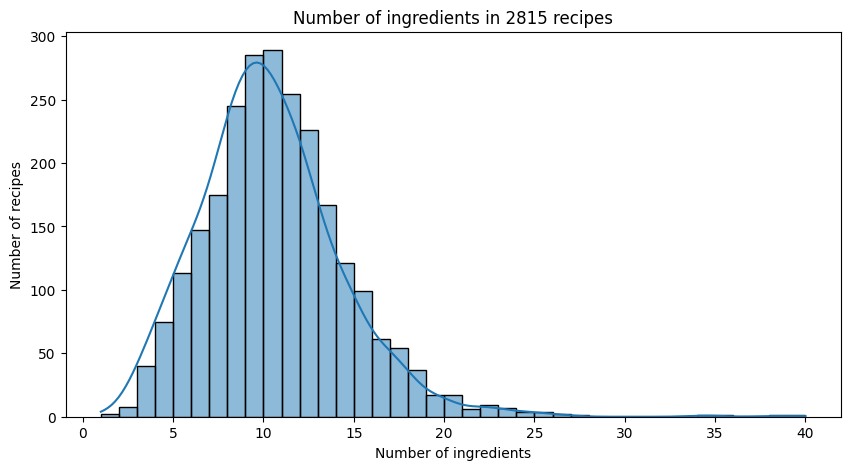

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def display_ingredients_histplot(recipes, binwidth=1):
    counts = [
        len(recipe["ingredients"])
        for recipe in recipes
        if recipe["ingredients"]
    ]

    plt.figure(figsize=(10, 5))
    sns.histplot(counts, kde=True, binwidth=binwidth)
    plt.title(f"Number of ingredients in {len(recipes)} recipes")
    plt.xlabel("Number of ingredients")
    plt.xticks(range(0, max(counts) + 1, 5))
    plt.ylabel("Number of recipes")

    plt.show()


display_ingredients_histplot(recipes)

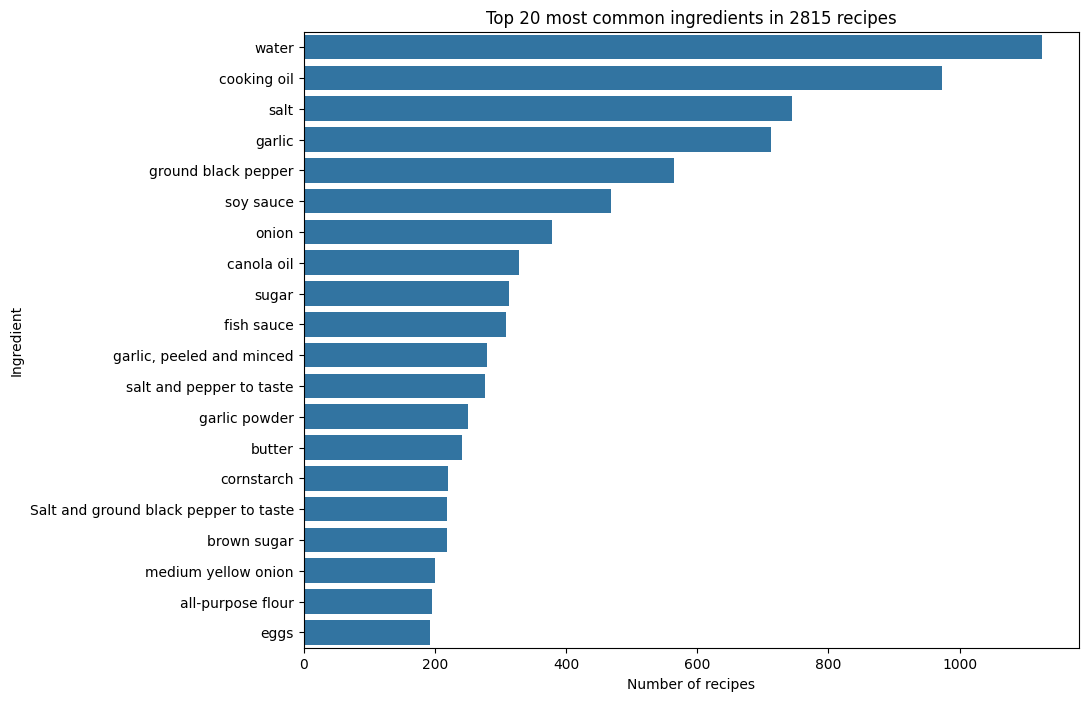

In [4]:
def display_common_ingredients(recipes, n=20):
    counts = {}
    for recipe in recipes:
        if not recipe["ingredients"]:
            continue
        for ingredient in recipe["ingredients"]:
            counts[ingredient] = counts.get(ingredient, 0) + 1

    sorted_ingredient_counts = sorted(
        counts.items(),
        key=lambda x: x[1],
        reverse=True,
    )
    top_n_ingredients = sorted_ingredient_counts[:n]

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=[x[1] for x in top_n_ingredients],
        y=[x[0] for x in top_n_ingredients],
    )
    plt.title(f"Top {n} most common ingredients in {len(recipes)} recipes")
    plt.xlabel("Number of recipes")
    plt.ylabel("Ingredient")

    plt.show()


display_common_ingredients(recipes)

### Save raw ingredients for reference

In [5]:
unique_ingredients = set()
for recipe in recipes:
    if not recipe["ingredients"]:
        continue
    unique_ingredients.update(recipe["ingredients"])

with open("data/unique_raw_ingredients.txt", "w", encoding="utf-8") as file:
    file.writelines("\n".join(sorted(unique_ingredients)))

## Preprocessing


### Remove recipes without ingredients

In [6]:
non_empty_recipes = [
    recipe
    for recipe in recipes
    if recipe["ingredients"]
]

len(non_empty_recipes), RECIPE_COUNT - len(non_empty_recipes)

(2469, 346)

### Tokenize

In [7]:
import spacy
from tabulate import tabulate

nlp = spacy.load("en_core_web_lg")


def display_tokens(text):
    """Display token attributes for a given string.""",
    rows = []
    for token in nlp(text):
        row = [
            token.text,
            token.lemma_,
            token.pos_,
            token.tag_,
            token.dep_,
            token.is_alpha,
        ]
        rows.append(row)
    headers = ["text", "lemma", "pos", "tag", "dep", "is_alpha"]
    print(tabulate(rows, headers=headers))


SAMPLE_INGREDIENT = (
    "14 oz. bean bean curd (sliced into 1/2 inch thick flat pieces)"
)
display_tokens(SAMPLE_INGREDIENT)

text    lemma    pos    tag    dep       is_alpha
------  -------  -----  -----  --------  ----------
14      14       NUM    CD     nummod    False
oz      oz       NOUN   NN     compound  True
.       .        PUNCT  .      punct     False
bean    bean     NOUN   NN     compound  True
bean    bean     NOUN   NN     compound  True
curd    curd     PROPN  NNP    ROOT      True
(       (        PUNCT  -LRB-  punct     False
sliced  slice    VERB   VBN    acl       True
into    into     ADP    IN     prep      True
1/2     1/2      NUM    CD     nummod    False
inch    inch     NOUN   NN     npadvmod  True
thick   thick    ADJ    JJ     amod      True
flat    flat     ADJ    JJ     amod      True
pieces  piece    NOUN   NNS    pobj      True
)       )        PUNCT  -RRB-  punct     False


### Lemmatize and remove non-ingredient words

In [8]:
def lemmatize_valid_nouns(ingredient):
    """Lemmatize valid nouns in a string.""",
    doc = nlp(ingredient)
    valid_lemmas = []
    for token in doc:
        if token.is_alpha and token.pos_ in ["NOUN", "PROPN"]:
            valid_lemmas.append(token.lemma_)
    return " ".join(valid_lemmas)


lemmatized = lemmatize_valid_nouns(SAMPLE_INGREDIENT)
display_tokens(lemmatized)

text    lemma    pos    tag    dep       is_alpha
------  -------  -----  -----  --------  ----------
oz      oz       NOUN   NN     compound  True
bean    bean     NOUN   NN     compound  True
bean    bean     NOUN   NN     compound  True
curd    curd     NOUN   NN     compound  True
inch    inch     NOUN   NN     compound  True
piece   piece    NOUN   NN     ROOT      True


### Remove culinary stop words

In [9]:
with open(f"data/culinary_stopwords.txt") as file:
    culinary_stopwords = [line.strip() for line in file]


def filter_stopwords(ingredient):
    """Filter out culinary stopwords from a string of terms."""
    clean_terms = []
    for term in ingredient.split():
        if term not in culinary_stopwords:
            clean_terms.append(term)
    return " ".join(clean_terms)


filtered = filter_stopwords(lemmatized)
display_tokens(filtered)

text    lemma    pos    tag    dep       is_alpha
------  -------  -----  -----  --------  ----------
bean    bean     NOUN   NN     compound  True
bean    bean     NOUN   NN     compound  True
curd    curd     NOUN   NN     ROOT      True


### Handle synonyms to standardize ingredients

In [10]:
with open("data/ingredient_synonyms.json") as file:
    ingredient_synonyms = json.load(file)


def handle_synonym(ingredient):
    """Replace ingredient synonyms with a common name."""
    return ingredient_synonyms.get(ingredient, ingredient)

common_name = handle_synonym(filtered)
display_tokens(common_name)  # ???: "tofu" is considered as a VERB

text    lemma    pos    tag    dep       is_alpha
------  -------  -----  -----  --------  ----------
bean    bean     NOUN   NN     compound  True
bean    bean     NOUN   NN     compound  True
curd    curd     NOUN   NN     ROOT      True


### Remove duplicate terms

In [11]:
def remove_duplicates(ingredients):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for ingredient in ingredients.split():
        if ingredient not in seen:
            unique.append(ingredient)
            seen.add(ingredient)
    return " ".join(unique)

unique_ingredient = remove_duplicates(common_name)
display_tokens(unique_ingredient)

text    lemma    pos    tag    dep       is_alpha
------  -------  -----  -----  --------  ----------
bean    bean     PROPN  NNP    compound  True
curd    curd     NOUN   NN     ROOT      True


### Define the entire preprocessing pipeline

In [12]:
def preprocess_ingredient(ingredient):
    """Preprocess an ingredient string to extract key terms.""",
    main_ingredient = ingredient.split("(")[0]
    first_alternative = main_ingredient.split(" or ")[0]
    formatted = first_alternative.lower().strip()

    lemmatized = lemmatize_valid_nouns(formatted)
    filtered = filter_stopwords(lemmatized)
    common_name = handle_synonym(filtered)
    unique_ingredient = remove_duplicates(common_name)

    return unique_ingredient


clean_ingredient = preprocess_ingredient(SAMPLE_INGREDIENT)
clean_ingredient

'bean curd'

### Apply the preprocessing pipeline

In [13]:
from tqdm import tqdm

cleaned_recipes = non_empty_recipes.copy()

for i, recipe in enumerate(tqdm(cleaned_recipes)):
    ingredients = set()
    for ingredient in recipe["ingredients"]:
        clean_ingredient = preprocess_ingredient(ingredient)
        if clean_ingredient and len(clean_ingredient) > 1:
            ingredients.add(clean_ingredient)
    cleaned_recipes[i]["ingredients"] = list(sorted(ingredients))

100%|██████████| 2469/2469 [01:20<00:00, 30.82it/s]


In [14]:
min_ingredient = 3
cleaned_recipes = [
    recipe
    for recipe in cleaned_recipes
    if recipe["ingredients"] and len(recipe["ingredients"]) > min_ingredient
]

len(cleaned_recipes), RECIPE_COUNT - len(cleaned_recipes)

(2074, 741)

### Generate the synonym dictionary

### Visualize cleaned ingredients

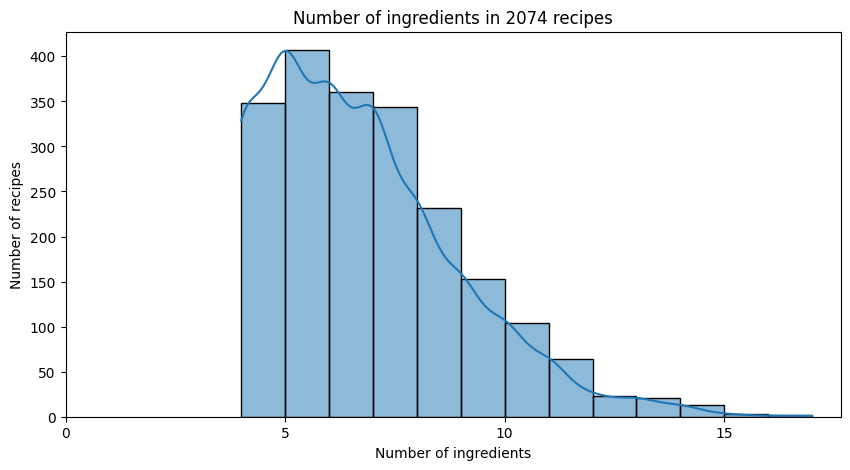

In [15]:
display_ingredients_histplot(cleaned_recipes)

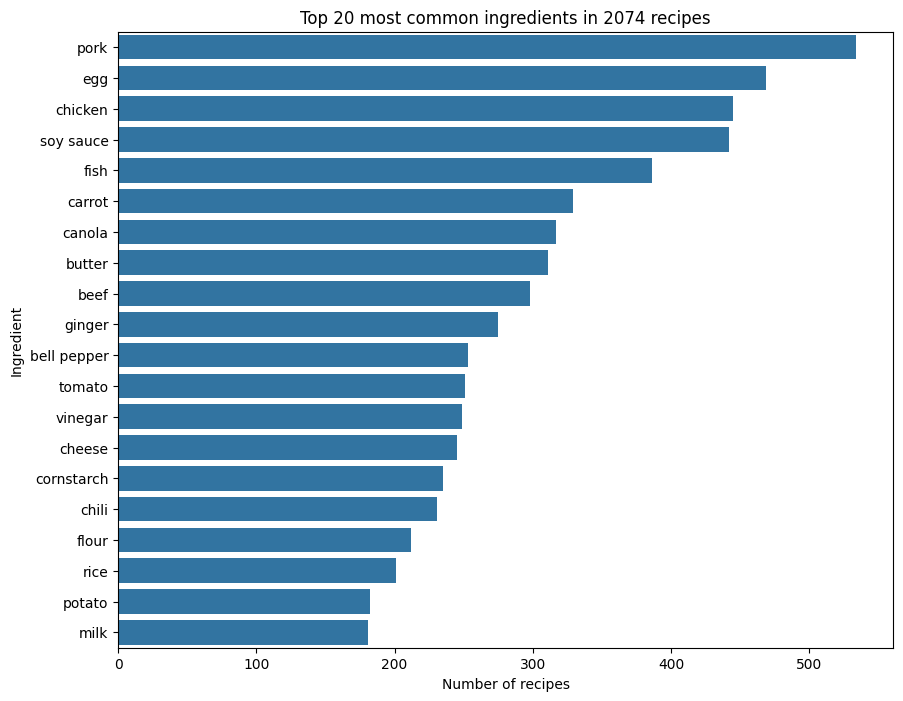

In [16]:
display_common_ingredients(cleaned_recipes)

## Vectorization


In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(
    [" ".join(recipe["ingredients"]) for recipe in cleaned_recipes],
    show_progress_bar=True,
)

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

## Dimensionality reduction

In [18]:
from sklearn.decomposition import TruncatedSVD

dimensions_to_keep = 150
svd = TruncatedSVD(n_components=dimensions_to_keep)
reduced_embeddings = svd.fit_transform(embeddings)

reduced_embeddings.shape

(2074, 150)

## Clustering


In [19]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 7
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
cluster_labels = clustering.fit_predict(reduced_embeddings)

## Visualization


In [21]:
import plotly.express as px
import pandas as pd

# Dimensionality reduction for visualization
dimensions_to_keep = 2
svd = TruncatedSVD(n_components=dimensions_to_keep)
reduced_embeddings = svd.fit_transform(reduced_embeddings)

ingredients_format = [
    "<br>".join(recipe["ingredients"]) for recipe in cleaned_recipes
]

df = pd.DataFrame(
    {
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "cluster": cluster_labels.astype(str),
        "recipe_name": [recipe["name"] for recipe in cleaned_recipes],
        "ingredients": ingredients_format,
    }
)

fig = px.scatter(
    df,
    x="x",
    y="y",
    color="cluster",
    hover_name="recipe_name",
    hover_data=["ingredients"],
    width=800,
    height=800,
)

fig.update_traces(marker=dict(size=5))
fig.update_layout(title="Ingredient-Based Clustering of Filipino Dishes")

fig.show()